Questo notebook prende spunto dal notebook Object_detection01.ipynb e utilizza anche in questo caso un  modello onditional-DETR model with ResNet-50 backbone. In questo caso però il modello è stato precedentemente sottoposto a fine-tuning al fine di individuare, all'interno di documenti digitali, la presenza di firme.


Per un'analisi completa delle diverse architetture di modelli utilizzabili per questa funzionalità vedi:
https://huggingface.co/blog/samuellimabraz/signature-detection-model.<br>

Anche in questo caso, come nel notebook predendente, vengono utilizzate entrambi le possibili possibilità di interagire con un modello HF:
- utilizzo tramite pipeline
- utilizzo diretto del modello (e del relativo processor)

N.B. 
L'immagine utilizzata è stata scaricata di internet!!

In [25]:
#!uv pip install ipywidgets

In [26]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("object-detection", 
                model="tech4humans/conditional-detr-50-signature-detector")

Device set to use cpu


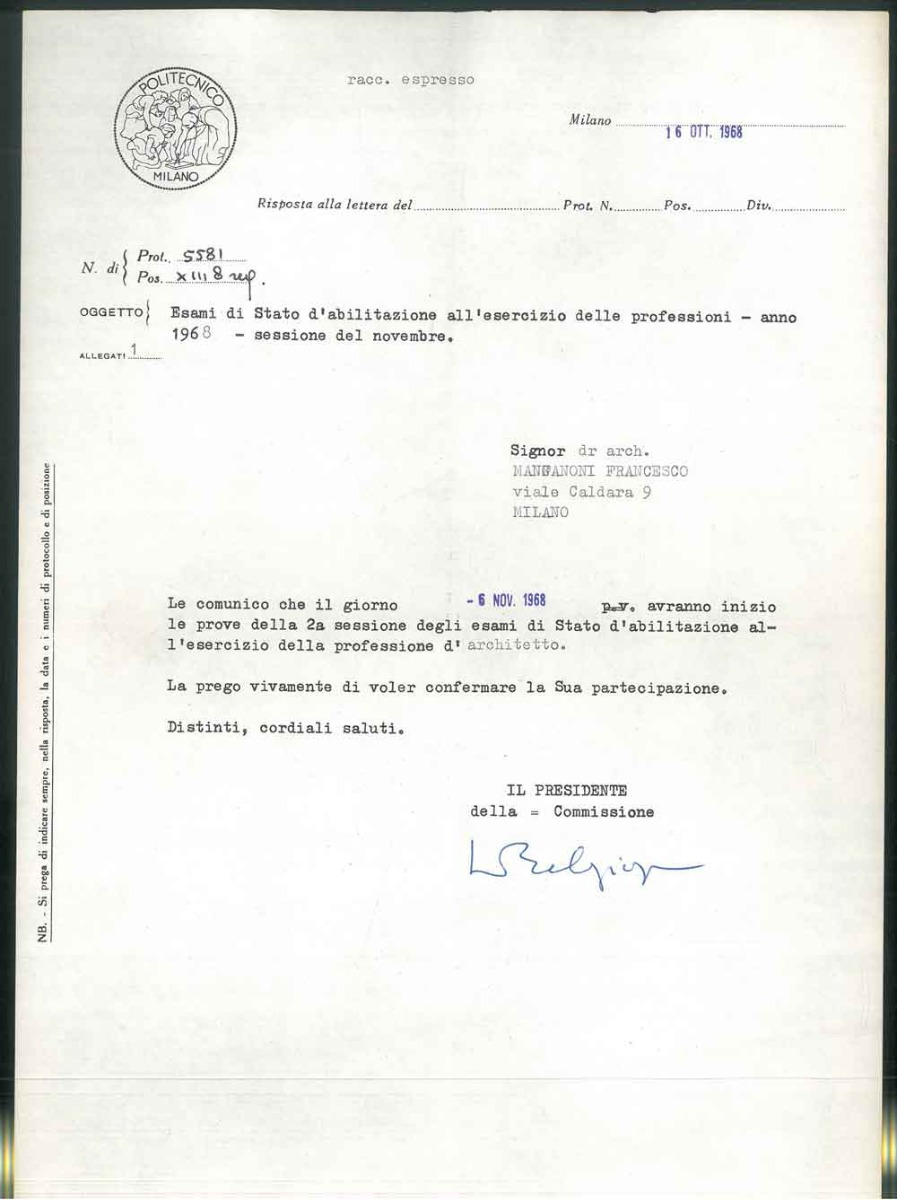

In [27]:
from PIL import Image, ImageDraw
import requests
import torch

def loadImage(url):
    if url.startswith('http'):  #1
        image = Image.open(requests.get(url, stream=True).raw)
    else:
        image = Image.open(url)  #2
    return image

image = loadImage('doc_firma.jpg')
display(image)

In [16]:
results = pipe(image)
results

[{'score': 0.8909025192260742,
  'label': 'signature',
  'box': {'xmin': 467, 'ymin': 833, 'xmax': 710, 'ymax': 896}}]

Detected signature with confidence 89.09% at [467, 833, 710, 896]


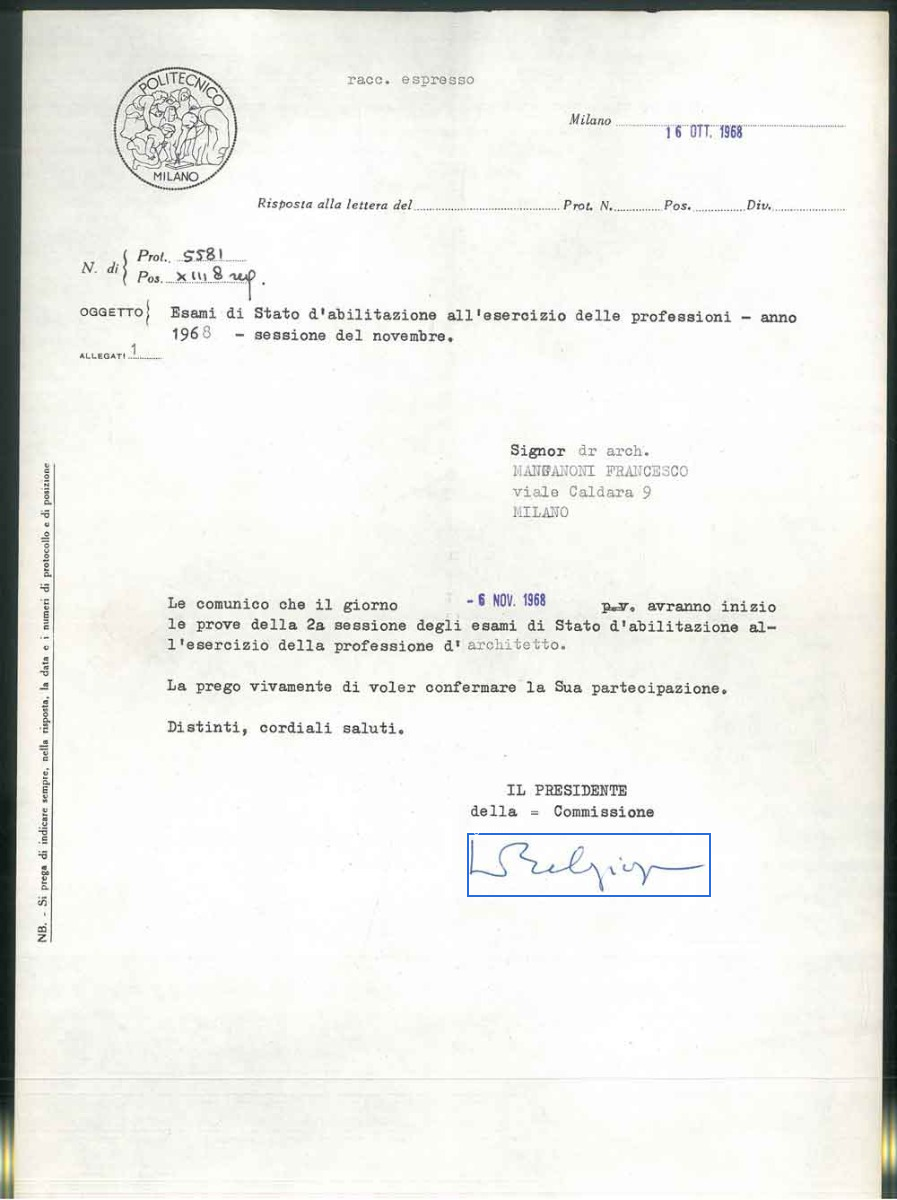

In [12]:
import random

draw = ImageDraw.Draw(image)

for object in results:
    box = [i for i in object['box'].values()]
    print(
        f"Detected {object['label']} with confidence "
        f"{(object['score'] * 100):.2f}% at {box}"
    )

    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    color = (r, g, b)

    draw.rectangle(box,  #1
                   outline=color,   #1
                   width=2)   #1

    draw.text((box[0], box[1]-10),  #2
              object['label'],   #2
              fill='white')   #2

display(image)

In [28]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("tech4humans/conditional-detr-50-signature-detector")
model = AutoModelForObjectDetection.from_pretrained("tech4humans/conditional-detr-50-signature-detector")

In [29]:
model.config.id2label

{0: 'signature'}

In [30]:
inputs = processor(images = image, return_tensors = "pt")

In [31]:
inputs

{'pixel_values': tensor([[[[-1.6213, -1.6213, -1.6042,  ..., -1.5357, -1.5699, -1.6213],
          [-1.6213, -1.6213, -1.6042,  ..., -1.5014, -1.5185, -1.5528],
          [-1.6213, -1.6213, -1.6042,  ..., -1.5357, -1.5357, -1.5699],
          ...,
          [-0.0458, -0.2171, -0.3027,  ..., -0.7137, -0.7650, -0.8849],
          [-0.0629, -0.2171, -0.2684,  ..., -0.7479, -0.8335, -0.9534],
          [ 1.1015,  1.0673,  1.0844,  ...,  0.7419,  0.7248,  0.6392]],

         [[-1.3354, -1.3354, -1.3179,  ..., -1.3179, -1.3354, -1.3529],
          [-1.3354, -1.3354, -1.3179,  ..., -1.2304, -1.2479, -1.2654],
          [-1.3354, -1.3354, -1.3179,  ..., -1.2304, -1.2304, -1.2654],
          ...,
          [ 0.2227, -0.0399, -0.2325,  ..., -0.3901, -0.5126, -0.6352],
          [ 0.2227, -0.0749, -0.2850,  ..., -0.4426, -0.5651, -0.6877],
          [ 1.4132,  1.2206,  1.0805,  ...,  1.0805,  1.0105,  0.9580]],

         [[-1.1770, -1.1770, -1.1596,  ..., -1.1944, -1.2293, -1.1944],
          [-1

In [32]:
outputs = model(**inputs)

In [50]:
target_sizes = torch.tensor([image.size[::-1]])

results = processor.post_process_object_detection(
              outputs,
              target_sizes = target_sizes,
              threshold = 0.8)[0]
results

{'scores': tensor([0.8909], grad_fn=<IndexBackward0>),
 'labels': tensor([0]),
 'boxes': tensor([[467.3714, 833.2315, 710.8264, 896.5706]], grad_fn=<IndexBackward0>)}

Detected signature with confidence 89.09% at [467.37, 833.23, 710.83, 896.57]


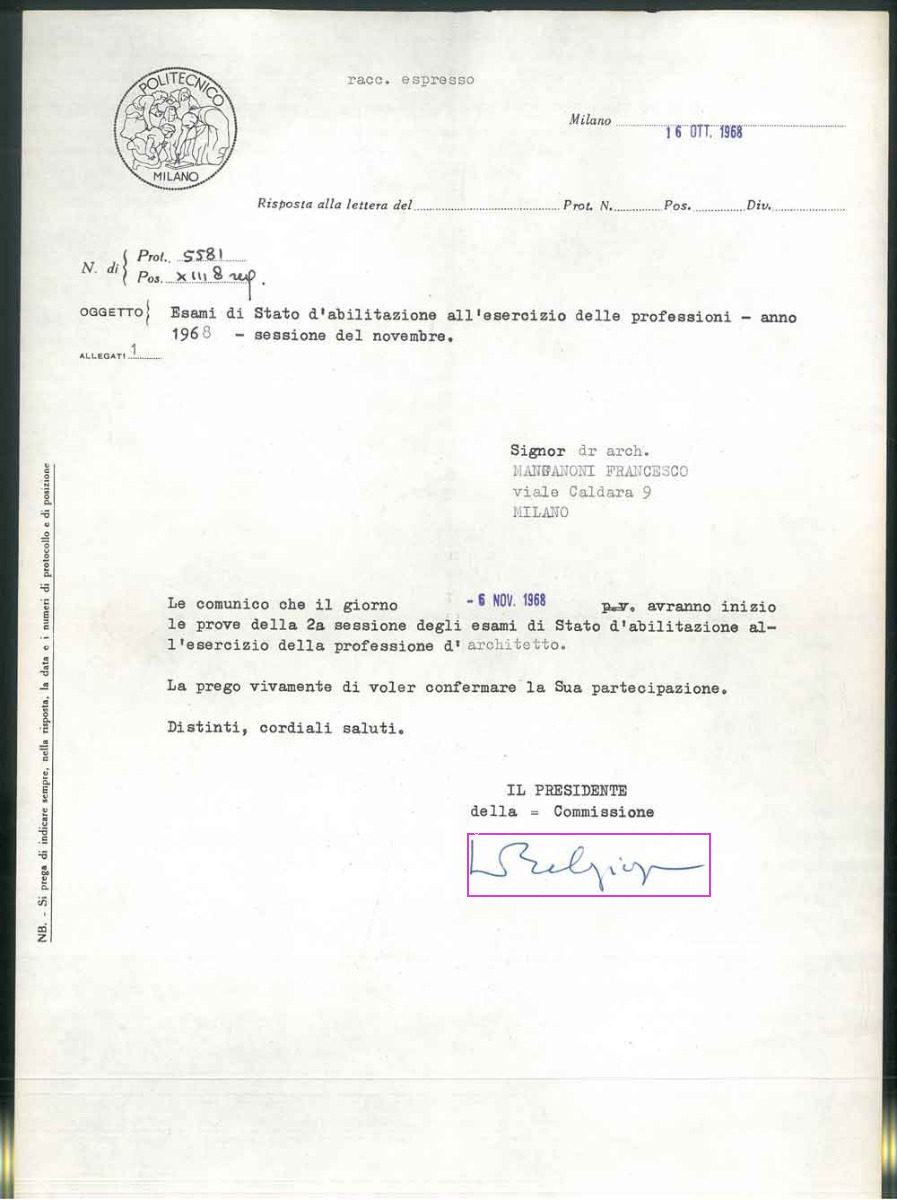

In [55]:
import random

draw = ImageDraw.Draw(image)

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{(score.item() * 100):.2f}% at {box}"
    )

    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    color = (r, g, b)

    draw.rectangle(box,  #1
                   outline=color,   #1
                   width=2)   #1

    draw.text((box[0], box[1]-10),  #2
              model.config.id2label[label.item()],   #2
              fill='white')   #2

display(image)